# Flu Shot Learning - Machine Learning Final Project

In [1]:
# Utilized data saved in google drive
""" from google.colab import drive
drive.mount('/content/drive') """;

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Project data in google drive
#DATA_PATH = Path.cwd()/"drive"/"MyDrive"/"APC"/"data";
# Project data from repository
DATA_PATH = Path.cwd()/".."/"data";

features_train = pd.read_csv(
    DATA_PATH/"training_set_features.csv",
    index_col="respondent_id"
)

labels_train = pd.read_csv(
    DATA_PATH/"training_set_labels.csv",
    index_col="respondent_id"
)

np.testing.assert_array_equal(features_train.index.values, labels_train.index.values)

### Logistic Regression Models

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier


from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 1337 # Fixed random seed for reproducibility

Initially we'll experiment with a logistic regression model considering only the numerical features variables. For this it is required to apply some processing to the feature set:
- **Scaling**: Transform all features to be on the same scale.
- **NA Imputation**: Logistic regression does not handle NA values (i.e when survey respondents leave out answers unfilled). Median imputation will be utilized, which fills these missing values with the median from the training data.

For a second model, we'll introduce the categorical features. Since these come in the form of string values, encoding is required to make them work within the logistic regression:
- **One-Hot Encoding**: In this form of encoding, different value possibilities within a feature are transformed into new binary variables. This is preferable

# Flu Shot Learning - Machine Learning Final Project

In [3]:
# Just the numerical features
numeric_col_index = features_train.columns[features_train.dtypes != "object"].values
# Categorical features
cat_col_index = features_train.columns[features_train.dtypes == 'object'].values

# Scaling and Imputation steps
numeric_preprocessing = Pipeline([
    ('standard_scaler', StandardScaler()),
    #('min_max_scaler', MinMaxScaler(feature_range=(0,1))),
    ('simpleImputer', SimpleImputer(strategy='median'))
])

categorical_preprocessing = Pipeline([
    ('Imputer', SimpleImputer(strategy='most_frequent')),
    ('Encoding', OneHotEncoder()) # This might not play nice with cat boost``
])

# Apply the preprocessing steps to a given feature column
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_preprocessing, numeric_col_index),
        ("categorical", categorical_preprocessing, cat_col_index),
    ], 
    remainder="drop"
)

# if the CatBoost Classifier is used, the results are better, but as the categorical features are already being encoded to numerical values (in this case One-Hot encoding)

estimators = MultiOutputClassifier(
    #estimator=DummyClassifier(strategy='uniform') # Random classifier for benchmarking
    #estimator=LogisticRegression(penalty="l2", C=1, max_iter=int(1e6), random_state=RANDOM_SEED, class_weight='balanced')
    #estimator=CatBoostClassifier(random_seed=RANDOM_SEED)
    #estimator=XGBClassifier(random_state = RANDOM_SEED)
    #estimator=GaussianNB()
    #estimator=MultinomialNB() # has to be used with positive values
    estimator=DecisionTreeClassifier(criterion='gini', splitter='best')
)

# FULL MODEL PIPELINE

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators)
])
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simpleImputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'b...
                                                                   OneHotEncoder())]),
                                                  array(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'], dtype=object))])),
                ('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression(C=1,
                                                                    class_weight='balanced',
                                                                    max_iter=1000000,
                                                                    random_state=1337)))])

Searching through several models and parameters using Grid Search CV:
[Multioutput Classifier with grid search](https://stackoverflow.com/questions/71902957/how-to-use-gridsearchcv-with-multioutputclassifiermlpclassifier-pipeline)

In [6]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_train,
    labels_train,
    test_size=0.25, # 25% of data entries will be used for validation
    shuffle=True,
    stratify=labels_train,
    random_state=RANDOM_SEED
)

search_space = [{'estimators__estimator': [LogisticRegression(penalty="l2", max_iter=int(1e6), random_state=RANDOM_SEED, class_weight='balanced')], 
'estimators__estimator__C': [0.01, 0.1, 1, 10],
'estimators__estimator__penalty': ['l1', 'l2']}]

clf = GridSearchCV(full_pipeline, search_space, verbose=1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('standard_scaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleImputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavior...
       'employment_occupation'], dtype=object))])),
                                       ('estimators',
                                        MultiOutputClassifier(estimator=LogisticRegression(C=1,
                                                                                           class_weight='balanced',
                                                                                           max_iter=1000000,
                                                                                           random_state=1337)))]),
             param_grid=[{'estimators__estimator': [LogisticRegression(C=0.1,
                                                                       class_weight='balanced',
                                                                       max_iter=1000000,
                                                                       random_state=1337)],
                          'estimators__estimator__C': [0.01, 0.1, 1, 10]}],
             verbose=1)

In [10]:
clf.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simpleImputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'b...
                                                                   OneHotEncoder())]),
                                                  array(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'], dtype=object))])),
                ('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression(C=0.1,
                                                                    class_weight='balanced',
                                                                    max_iter=1000000,
                                                                    random_state=1337)))])

#### Training and Evaluation

In [11]:
# Split the training data into two data sets, training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(
    features_train,
    labels_train,
    test_size=0.25, # 25% of data entries will be used for validation
    shuffle=True,
    stratify=labels_train,
    random_state=RANDOM_SEED
)

# Train the model
full_pipeline.fit(X_train, y_train)
# Evaluate
preds = full_pipeline.predict_proba(X_eval);

For the predictions, the pipeline has returned two arrays of predictions, one for each label `seasonal_vaccine` and `h1n1_vaccine`. Within each vector there are two classes, 0 and 1, so we'll only need the values of the second column (which correspond to the probability of having taken the vaccine)

In [13]:
y_preds = pd.DataFrame({
    "h1n1_vaccine": preds[0][:, 1],
    "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
y_preds.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
8004,0.281830,0.926032
20429,0.430578,0.624329
6634,0.098105,0.027943
9580,0.973949,0.954078
20754,0.419272,0.451555


#### Performance Metrics (ROC)

To measure the performance of the classifications performed between different classifiers, the ROC (Receiver Operating Characteristic) metric was utilized. The ROC is a type of plot used in binary classifiers, which measures the True Positive Rate against the False Positive Rate for different classifier thresholds. To obtain a quantitative measurement of the performance obtained, it it possible to take the area beneath the curve.

0.8465458700347632


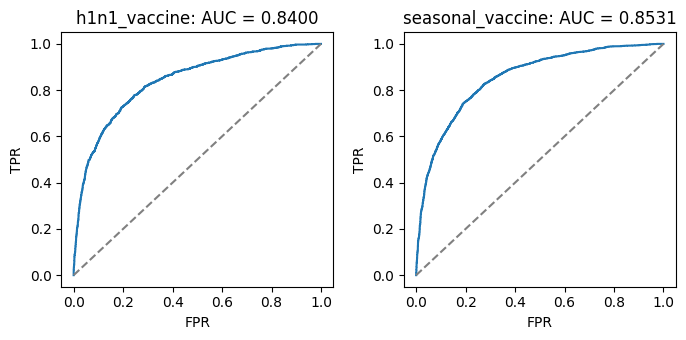

In [14]:
def plot_roc(y_true, y_score, label_name, ax : plt.Axes):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'], 'h1n1_vaccine', ax=ax[0])
plot_roc(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'], 'seasonal_vaccine', ax=ax[1])
fig.tight_layout()

# Final score,
print(roc_auc_score(y_eval, y_preds))

### Generating predictions for the competition

Before generating predictions for the competition, we'll train the model once again but now using the entire training set.

In [15]:
# Train the model once again using the entire training dataset
clf.best_estimator_.fit(features_train, labels_train);

In [17]:
from os import makedirs
""" Model should be a class containing a function named predict_proba()
"""
def makeSubmissionCSV(model, outputFilename):
    test_features = pd.read_csv(DATA_PATH / "test_set_features.csv", index_col="respondent_id")
    # Run the competition's test set to generate predictions
    test_probas = model.predict_proba(test_features)

    submission = pd.read_csv(DATA_PATH / "submission_format.csv", index_col = "respondent_id")
    # Verify that the columns are in the right order
    np.testing.assert_array_equal(test_features.index.values,
        submission.index.values)

    # Select the probabilities a person has taken each vaccine
    submission["h1n1_vaccine"] = test_probas[0][:, 1]
    submission["seasonal_vaccine"] = test_probas[1][:, 1]

    makedirs(Path.cwd().parent / "out", exist_ok=True); # create if non-existent
    submission.to_csv(Path.cwd().parent / "out" / outputFilename, index=True)

makeSubmissionCSV(clf.best_estimator_, "logistic_C0.01_submission.csv")